# Library

In [ ]:
import torch
from torch.optim import Adam
import torch.nn as nn
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from datasets import load_dataset, DatasetDict, Dataset
from tqdm.notebook import tqdm
from PIL import ImageEnhance, Image
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import io
import random
from huggingface_hub import login, HfApi
import cv2

from collections import Counter

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

# Load dataset

In [ ]:
original_cars_df = load_dataset('khoadole/cars_8k_balance_dataset')
cars_df = pd.DataFrame(original_cars_df["train"])

### Remove no car images

In [ ]:
# Load model
def load_model():
	model = torch.hub.load('ultralytics/yolov5', 'yolov5x', pretrained=True)
	model.conf = 0.6 # decrease confidence => higher car detect : min 0.1(conf)
	return model

def get_no_cars_rows(df : pd.DataFrame, no_cars_path : str, no_cars_rows : list):
	model = load_model()
	for index, row in tqdm(df.iterrows(), total=len(df)):
		image_bytes = row['image']

		image_raw = Image.open(io.BytesIO(image_bytes["bytes"]))
		image = image_raw
		image = image.resize((640, 480), Image.LANCZOS)

		enhancer = ImageEnhance.Brightness(image)
		image = enhancer.enhance(0.5)
		enhancer = ImageEnhance.Contrast(image)
		image = enhancer.enhance(0.5)

		results = model(image)

		detections = results.pandas().xyxy[0]

		if 'car' in detections['name'].values:
			print()
		else:
			# Save raw no car detected images
			# no_cars_path.mkdir(exist_ok=True)
			# image_raw.save(no_cars_path / f"{index}.jpg")

			# results.show()
			# display(image)

			no_cars_rows.append(index)

	return no_cars_rows

# Save cols
def save_file(filename: str, data : list):
	with open(filename, "w") as file:
		file.write("\n".join(map(str, data)))

# Load cols
def load_cols(filename: str):
	with open(filename, "r") as file:
		data = [int(line.strip()) for line in file]
	return data

# Load dataframe
cars_short = cars_df
# no_cars_rows = load_cols("no_cars_rows.txt")

## Load cols from file(if exists)
if Path("no_cars_rows_0_6.txt").exists():
	no_cars_rows = load_cols("no_cars_rows_0_6.txt")
else:
	# Path
	cwd = Path.cwd()
	no_cars_dir = cwd / 'no_cars_detected'

	no_cars_rows = []
	no_cars_rows = get_no_cars_rows(cars_short, no_cars_dir, no_cars_rows)

	save_file("no_cars_rows_0_6.txt", no_cars_rows)

# Drop rows
cars_short.drop(no_cars_rows, inplace=True)

# Split train, validation, test

In [ ]:
train, temp = train_test_split(cars_short, test_size=0.4, stratify=cars_short["name"], random_state=14)
validation, test = train_test_split(temp, test_size=0.5, stratify=temp["name"], random_state=14)

Exterior color
white     1655
black     1012
gray       746
silver     701
blue       167
Name: count, dtype: int64


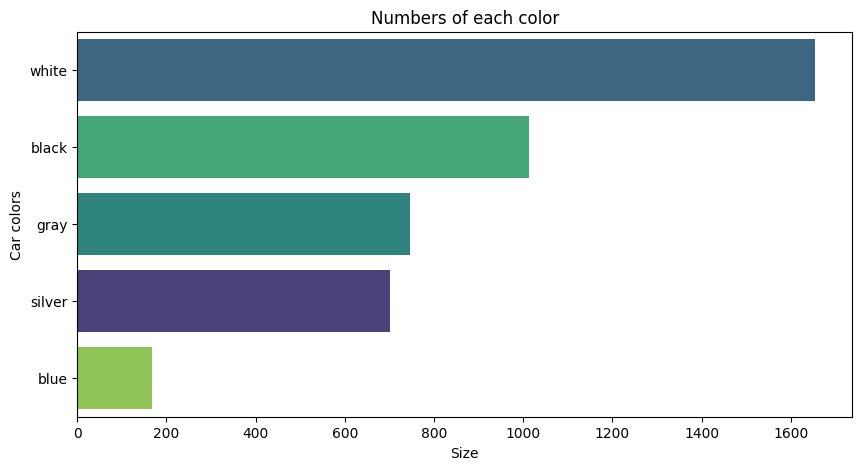

In [ ]:
print(train["Exterior color"].value_counts())
import seaborn as sns
plt.figure(figsize=(10, 5))
sns.countplot(y=train["Exterior color"], hue=train["Exterior color"], order=train["Exterior color"].value_counts().index, palette="viridis", legend=False)
plt.title("Numbers of each color")
plt.xlabel("Size")
plt.ylabel("Car colors")
plt.show()

Exterior color
white     518
black     368
silver    248
gray      245
blue       48
Name: count, dtype: int64


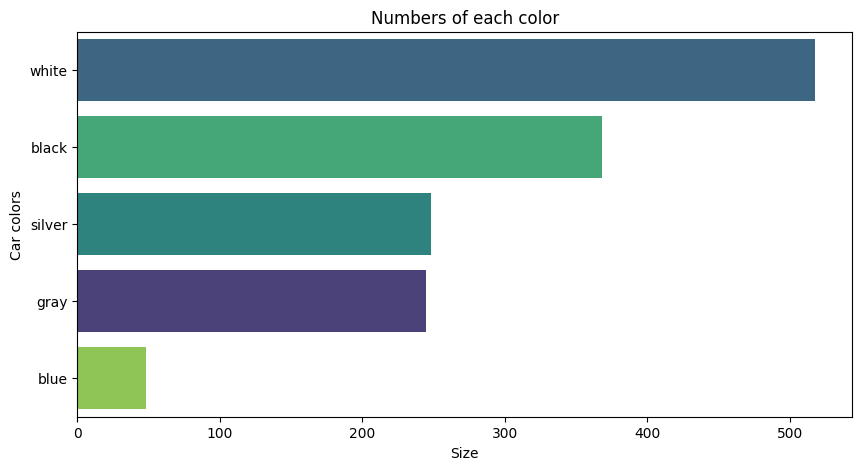

In [ ]:
print(test["Exterior color"].value_counts())
import seaborn as sns
plt.figure(figsize=(10, 5))
sns.countplot(y=test["Exterior color"], hue=test["Exterior color"], order=test["Exterior color"].value_counts().index, palette="viridis", legend=False)
plt.title("Numbers of each color")
plt.xlabel("Size")
plt.ylabel("Car colors")
plt.show()

Exterior color
white     583
black     313
gray      265
silver    218
blue       48
Name: count, dtype: int64


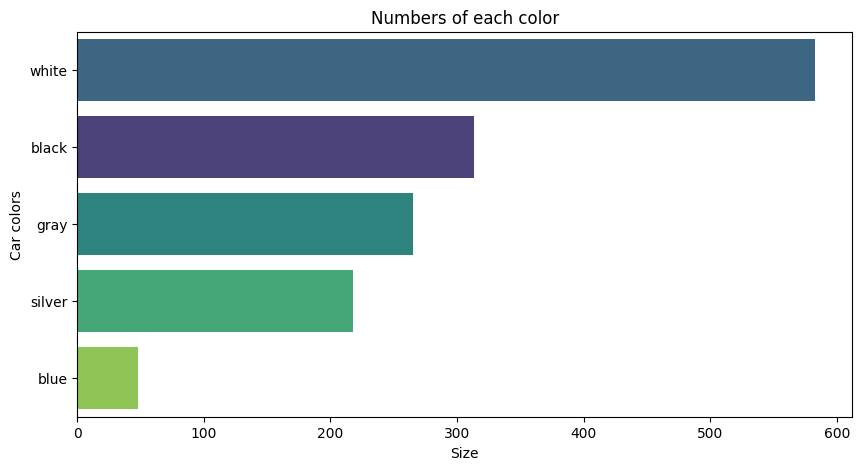

In [ ]:
print(validation["Exterior color"].value_counts())
import seaborn as sns
plt.figure(figsize=(10, 5))
sns.countplot(y=validation["Exterior color"], hue=validation["Exterior color"], order=validation["Exterior color"].value_counts().index, palette="viridis", legend=False)
plt.title("Numbers of each color")
plt.xlabel("Size")
plt.ylabel("Car colors")
plt.show()

### Augmentation data

In [ ]:
import pandas as pd
import math
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, array_to_img

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

def image_augmentation_all_colors(df: pd.DataFrame, car_type: str, num_samples: int):
    car_subset = df[df["name"] == car_type].copy()

    color_counts = car_subset["Exterior color"].value_counts().to_dict()
    num_colors = len(color_counts)

    samples_per_color = {color: math.ceil(num_samples / num_colors) for color in color_counts.keys()}

    total = sum(samples_per_color.values())
    if total > num_samples:
        diff = total - num_samples
        for color in sorted(color_counts, key=color_counts.get, reverse=True):
            if diff <= 0:
                break
            if samples_per_color[color] > 1:
                samples_per_color[color] -= 1
                diff -= 1

    new_rows = []

    for color, count in samples_per_color.items():
        color_subset = car_subset[car_subset["Exterior color"] == color]

        if len(color_subset) == 0:
            continue

        for i in range(count):
            source_row = color_subset.sample(1).iloc[0].copy()

            try:
                image_data = source_row['image']["bytes"]

                import io
                from PIL import Image
                img = Image.open(io.BytesIO(image_data))

                x = img_to_array(img)
                x = np.expand_dims(x, axis=0)  # Reshape (1, height, width, channels)

                aug_iter = datagen.flow(x, batch_size=1)
                # aug_image = aug_iter.next()[0].astype('uint8')
                aug_image = next(aug_iter)[0].astype('uint8')

                aug_pil = array_to_img(aug_image)

                buffer = io.BytesIO()
                aug_pil.save(buffer, format='JPEG')  # hoặc format phù hợp
                new_image_data = buffer.getvalue()

                source_row['image'] = {"bytes": new_image_data}

            except Exception as e:
                print(f"Error augmenting image: {e}")
            source_row['id'] = df['id'].max() + len(new_rows) + 1

            new_rows.append(source_row)

    if new_rows:
        return pd.DataFrame(new_rows)
    else:
        return pd.DataFrame()

# Blue
def image_augmentation(df: pd.DataFrame, car_type: str, num_samples: int):
    car_subset = df[df["name"] == car_type].copy()

    blue_subset = car_subset[car_subset["Exterior color"].str.lower() == "blue"]

    if len(blue_subset) == 0:
        print(f"No blue cars found for {car_type}")
        return pd.DataFrame()

    new_rows = []

    for i in range(num_samples):
        source_row = blue_subset.sample(1).iloc[0].copy()

        try:
            image_data = source_row['image']["bytes"]

            img = Image.open(io.BytesIO(image_data))

            x = img_to_array(img)
            x = np.expand_dims(x, axis=0)  # Reshape (1, height, width, channels)

            aug_iter = datagen.flow(x, batch_size=1)
            aug_image = next(aug_iter)[0].astype('uint8')

            aug_pil = array_to_img(aug_image)
            # display(aug_pil)
            # break
            buffer = io.BytesIO()
            aug_pil.save(buffer, format='JPEG')
            new_image_data = buffer.getvalue()

            source_row['image'] = {"bytes": new_image_data}

        except Exception as e:
            print(f"Error augmenting image: {e}")
        source_row['id'] = df['id'].max() + len(new_rows) + 1

        new_rows.append(source_row)

    if new_rows:
        return pd.DataFrame(new_rows)
    else:
        return pd.DataFrame()

def balance_data(df: pd.DataFrame, threshold: int):
    type_counts = df["name"].value_counts()

    # Find car types below threshold
    type_under_threshold = type_counts[type_counts < threshold]
    type_under_threshold_dict = {car_type: threshold - count for car_type, count in type_under_threshold.items()}

    # Create a copy of the input DataFrame to avoid modifying the original
    balanced_df = df.copy()

    # Augment each car type that's below the threshold
    for car_type, num_needed in type_under_threshold_dict.items():
        print(f"Augmenting {car_type}: need {num_needed} more samples")

        # Generate augmented samples
        new_cars = image_augmentation(balanced_df, car_type, num_needed)

        if not new_cars.empty:
            balanced_df = pd.concat([balanced_df, new_cars], ignore_index=True)

    return balanced_df

# threshold = 100
# train 700 => 300
# test 250 => 100
# val 200
train = balance_data(df=train, threshold=300)
validation = balance_data(df=validation, threshold=100)
test = balance_data(df=test, threshold=100)

# print(cars_balanced["name"].value_counts())

Augmenting Bentley Bentayga: need 55 more samples
Augmenting Audi Q7: need 86 more samples
Augmenting Audi Q3: need 101 more samples
Augmenting Acura TLX: need 124 more samples
No blue cars found for Acura TLX
Augmenting Audi A4: need 130 more samples
Augmenting BMW 330: need 158 more samples
Augmenting Bentley Flying: need 172 more samples
Augmenting BMW X1: need 173 more samples
Augmenting Acura ILX: need 209 more samples
No blue cars found for Acura ILX
Augmenting Bentley Mulsanne: need 256 more samples
No blue cars found for Bentley Mulsanne
Augmenting Bentley Bentayga: need 18 more samples
Augmenting Audi Q7: need 29 more samples
Augmenting Audi Q3: need 34 more samples
Augmenting Acura TLX: need 41 more samples
No blue cars found for Acura TLX
Augmenting Audi A4: need 43 more samples
Augmenting BMW 330: need 53 more samples
No blue cars found for BMW 330
Augmenting Bentley Flying: need 57 more samples
Augmenting BMW X1: need 58 more samples
No blue cars found for BMW X1
Augmentin

name
Bentley Continental    540
Audi Q5                508
BMW X3                 497
Acura MDX              486
Acura RDX              359
BMW X5                 355
Audi Q3                300
Bentley Bentayga       300
Audi A4                300
BMW 330                300
Audi Q7                300
BMW X1                 300
Bentley Flying         300
Acura TLX              176
Acura ILX               91
Bentley Mulsanne        44
Name: count, dtype: int64
Exterior color
white     1655
blue      1042
black     1012
gray       746
silver     701
Name: count, dtype: int64
brand
bmw        1452
audi       1408
bentley    1184
acura      1112
Name: count, dtype: int64


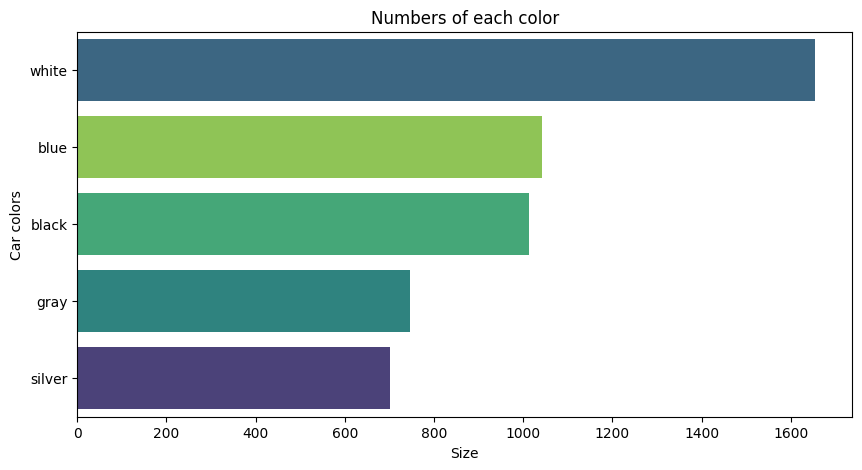

In [ ]:
print(train["name"].value_counts())
print(train["Exterior color"].value_counts())
print(train["brand"].value_counts())
import seaborn as sns
plt.figure(figsize=(10, 5))
sns.countplot(y=train["Exterior color"], hue=train["Exterior color"], order=train["Exterior color"].value_counts().index, palette="viridis", legend=False)
plt.title("Numbers of each color")
plt.xlabel("Size")
plt.ylabel("Car colors")
plt.show()

name
Bentley Continental    180
Audi Q5                169
BMW X3                 166
Acura MDX              162
Acura RDX              119
BMW X5                 119
Audi A4                100
Bentley Bentayga       100
Bentley Flying         100
Audi Q7                100
Audi Q3                100
Acura TLX               59
BMW 330                 47
BMW X1                  42
Acura ILX               30
Bentley Mulsanne        15
Name: count, dtype: int64
Exterior color
white     583
black     313
gray      265
blue      229
silver    218
Name: count, dtype: int64
brand
audi       469
bentley    395
bmw        374
acura      370
Name: count, dtype: int64


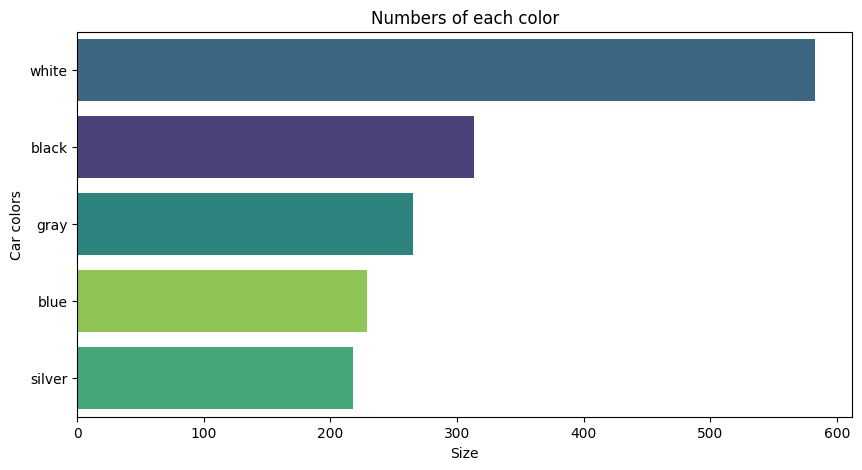

In [ ]:
print(validation["name"].value_counts())
print(validation["Exterior color"].value_counts())
print(validation["brand"].value_counts())
import seaborn as sns
plt.figure(figsize=(10, 5))
sns.countplot(y=validation["Exterior color"], hue=validation["Exterior color"], order=validation["Exterior color"].value_counts().index, palette="viridis", legend=False)
plt.title("Numbers of each color")
plt.xlabel("Size")
plt.ylabel("Car colors")
plt.show()

# Make QA

In [ ]:
# Load questions
with open('brand_questions.txt', 'r') as f:
    brand_questions = f.read().splitlines()
with open('color_questions.txt', 'r') as f:
    color_questions = f.read().splitlines()
with open('type_questions.txt', 'r') as f:
    type_questions = f.read().splitlines()

###
def pipeline_create_qa_dataset(df : pd.DataFrame):
    qa_dataset = []
    for index, row in tqdm(df.iterrows(), total=len(df)):
        # key = row["name"]

        # Get questions list
        brand_q = random.choice(brand_questions)
        color_q = random.choice(color_questions)
        type_q = random.choice(type_questions)

        qa_dataset.append({
            "id": row['id'],
            "image": row['image'],
            "question": brand_q,
            "answer": row['brand'],
        })
        qa_dataset.append({
            "id": row['id'],
            "image": row['image'],
            "question": color_q,
            "answer": row['Exterior color'],
        })
        qa_dataset.append({
            "id": row['id'],
            "image": row['image'],
            "question": type_q,
            "answer": row['name'],
        })
    return qa_dataset

###
train = pipeline_create_qa_dataset(train)
validation = pipeline_create_qa_dataset(validation)
test = pipeline_create_qa_dataset(test)

train = pd.DataFrame(train)
validation = pd.DataFrame(validation)
test = pd.DataFrame(test)

  0%|          | 0/5156 [00:00<?, ?it/s]

  0%|          | 0/1608 [00:00<?, ?it/s]

  0%|          | 0/1718 [00:00<?, ?it/s]

# Upload Huggingface

In [ ]:
def upload_to_huggingface(train, validation, test, dtaset_name, token):
    login(token=token)
    api = HfApi()

    # dataset = Dataset.from_pandas(dataset_df)
    train_dataset = Dataset.from_pandas(train)
    validation_dataset = Dataset.from_pandas(validation)
    test_dataset = Dataset.from_pandas(test)

    dataset_dict = DatasetDict({
        'train': train_dataset,
        'validation': validation_dataset,
        'test': test_dataset,
    })

    dataset_dict.push_to_hub(dataset_name)

    print(f"Dataset uploaded successfully to {dataset_name}")
    print(f"Access your dataset at: https://huggingface.co/datasets/{dataset_name}")

dataset_name = "khoadole/cars_8k_balance_dataset_full_augmented_v2"
token = "YOUR_HF_TOKEN"
# upload_to_huggingface(train, validation, test, dataset_name, token)

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/155 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/49 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/52 [00:00<?, ?ba/s]

Dataset uploaded successfully to khoadole/cars_8k_balance_dataset_full_augmented_v2
Access your dataset at: https://huggingface.co/datasets/khoadole/cars_8k_balance_dataset_full_augmented_v2
